In [1]:
# import statements
import keras
import numpy as np
import os
import json
import random
import cv2 as cv
import tensorflow as tf
import imageio
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Flatten, Input, UpSampling2D, Concatenate, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dense, Dropout, RandomFlip
from tensorflow.keras.optimizers import Adam

from facial_keypoint_detection import *

In [2]:
# HYPERPARAMETERS
params = {'IMG_H': 512, # model input: image height
          'IMG_W': 512, # model input: image width
          'CHANNELS': 3} # model input: image color channels

augment_params = {'translate': 0.2,
                  'noise': 0.05,
                  'contrast': 0.25,
                  'brightness': 0.2,
                  'zoom': 0.2,
                  'blur': 0.2}

In [3]:
# open up the json annotation file
annotations_file = open(os.getcwd() + '/data/all_data.json')
annotations = json.load(annotations_file)

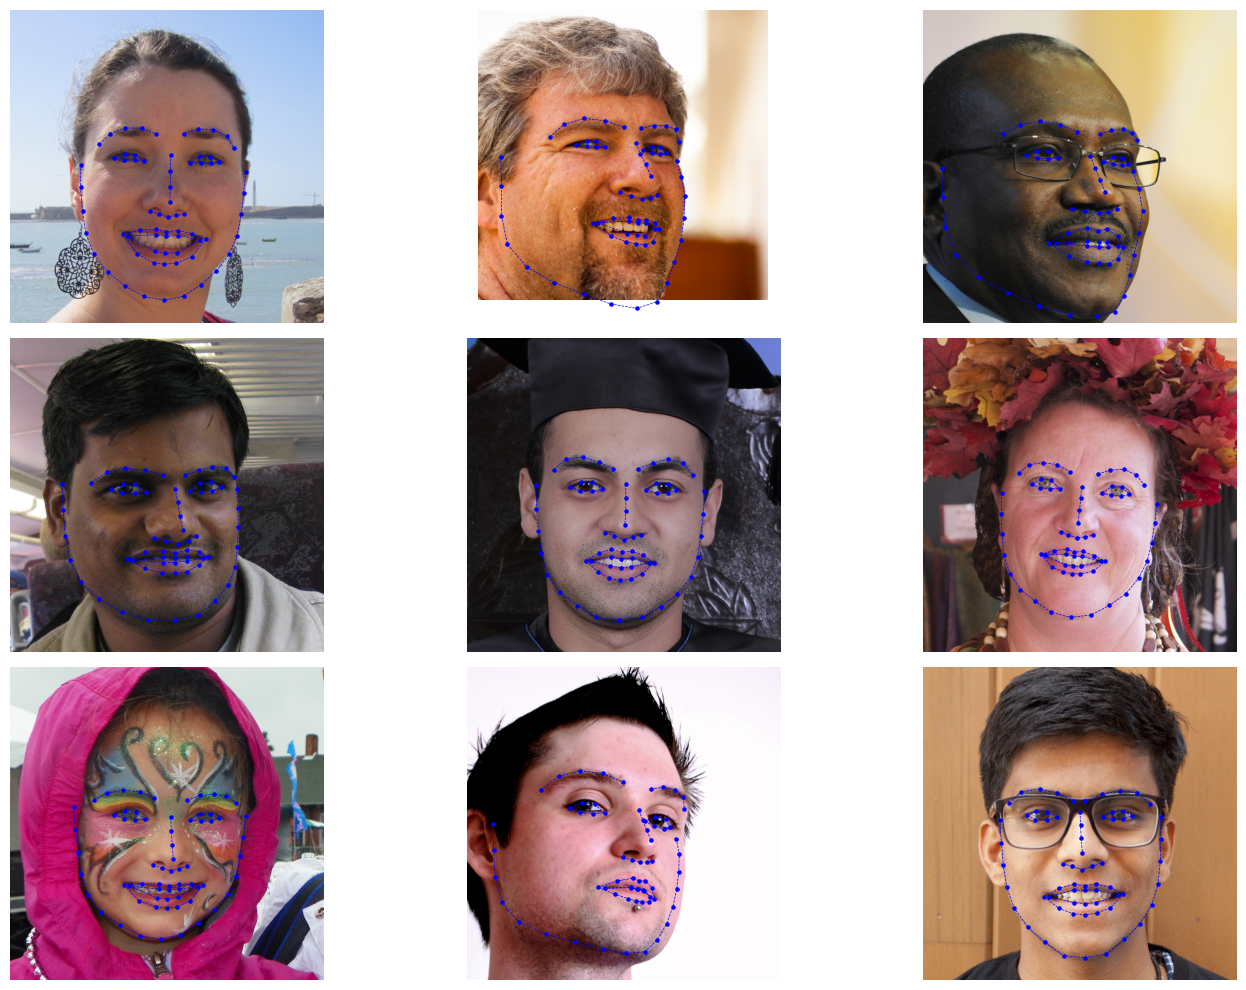

In [4]:
# VISUAL INSPECTION OF DATA SAMPLE
plt.figure(figsize = (15,10))
sampled_indices = np.random.choice(range(len(annotations)), 9, replace = False)
for i in range(0, 9, 1):
    ax = plt.subplot(3, 3, i+1)
    kp = show_sample(index = sampled_indices[i], 
                     annotations = annotations, 
                     color = 'blue', 
                     point_size = 5, 
                     linewidth = 0.5)
    pass
plt.tight_layout()
plt.show()

### Train-Test Split

In [5]:
# TRAIN-TEST SPLIT
n = len(annotations)
X_train, X_test, Y_train, Y_test = train_test_split(range(n), range(n), test_size = 0.01, random_state = 25)

print('X_train size: ', str(len(X_train)))
print('Y_train size: ', str(len(Y_train)))
print('X_test size: ', str(len(X_test)))
print('Y_test size: ', str(len(Y_test)))

X_train size:  4950
Y_train size:  4950
X_test size:  50
Y_test size:  50


### Data Augmentation

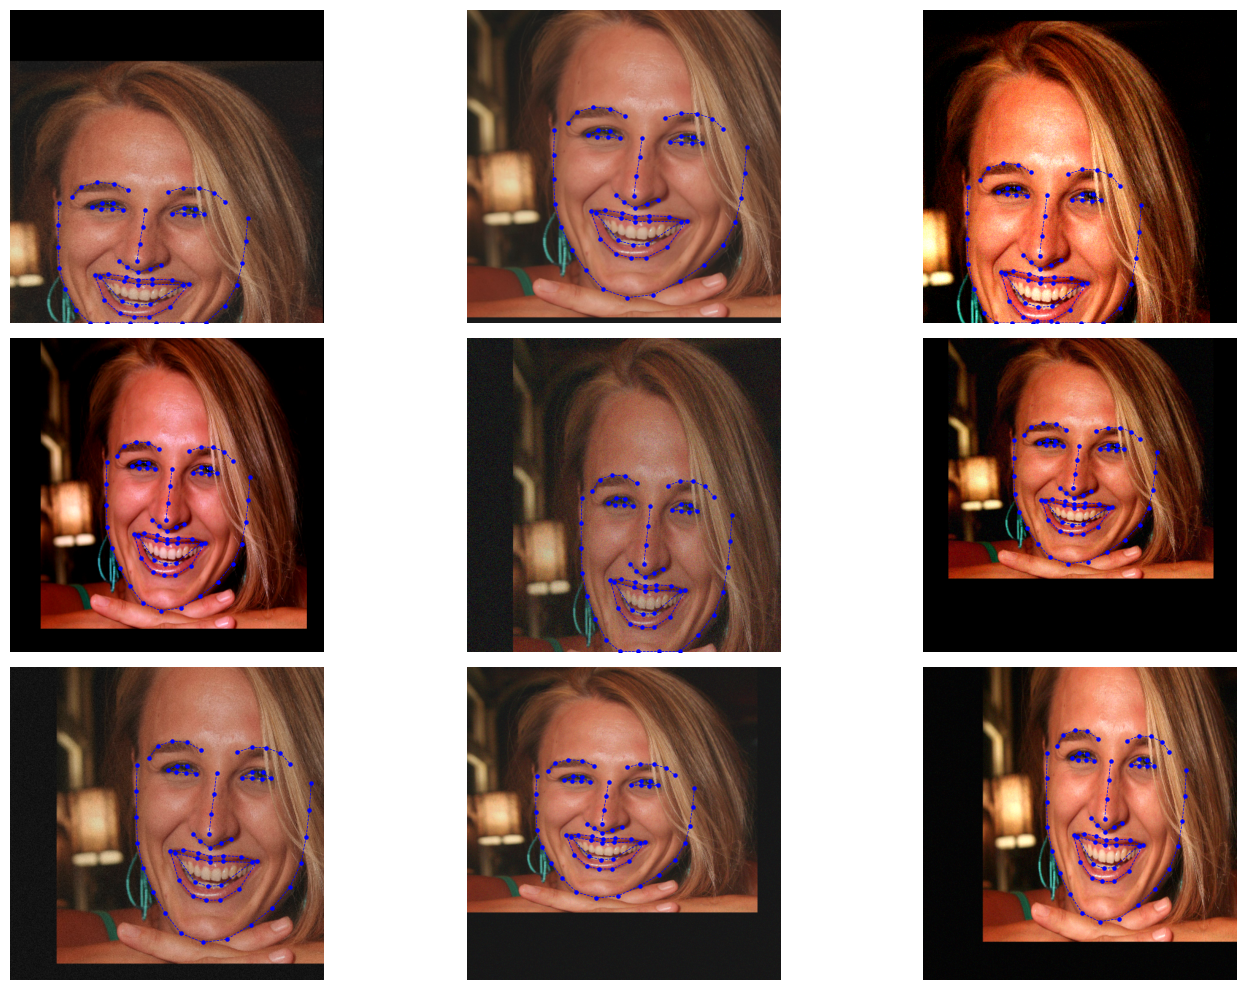

In [6]:
# inspect augmentations
plt.figure(figsize = (15,10))
sampled_indices = np.random.choice(range(len(annotations)), 9, replace = False)
for i in range(0, 9, 1):
    ax = plt.subplot(3, 3, i+1)
    ins, tar = preprocess_with_augmentation(index = 1, #sampled_indices[i], 
                                            anns = annotations, 
                                            augment_params = augment_params, 
                                            params = params)
    kps = show(img = ins, 
               keypoints = tar, 
               params = params, 
               color = 'blue', 
               point_size = 5, 
               linewidth = 0.5)
    pass
plt.tight_layout()
plt.show()

### Data Generators

In [7]:
# training data generator
TRAIN_gen = train_data_generator(indices = X_train, 
                                 batch_size = 8, 
                                 annotations = annotations, 
                                 params = params, 
                                 augment_params = augment_params)

img, targets = TRAIN_gen.__getitem__(0)

print('TRAINING DATA GENERATOR')
print('----------------------')
print('INPUTS:')
print('Images: ', img.shape)
print('----------------------')
print('TARGETS:')
print('Targets: ', targets.shape)
print('----------------------')
print(' ')

# test data generator
TEST_gen = test_data_generator(indices = X_test, 
                               batch_size = 8, 
                               annotations = annotations, 
                               params = params)

img, targets = TEST_gen.__getitem__(0)

print('TEST DATA GENERATOR')
print('----------------------')
print('INPUTS:')
print('Images: ', img.shape)
print('----------------------')
print('TARGETS:')
print('Targets: ', targets.shape)

TRAINING DATA GENERATOR
----------------------
INPUTS:
Images:  (8, 512, 512, 3)
----------------------
TARGETS:
Targets:  (8, 136)
----------------------
 
TEST DATA GENERATOR
----------------------
INPUTS:
Images:  (8, 512, 512, 3)
----------------------
TARGETS:
Targets:  (8, 136)


### Facial Key Point Detector Model

In [8]:
# function to create a feature extractor backbone to regressor head model
def get_model():

    img_input = Input([params['IMG_H'], params['IMG_W'], params['CHANNELS']], name = 'input')

    x = Conv2D(filters = 16, kernel_size = 3, strides = 1, activation = 'relu', padding = "same", name = 'conv_1')(img_input)
    x = BatchNormalization(name = 'batchnorm_1')(x)
    x = MaxPooling2D(name = 'maxpool_1')(x)
    
    x = Conv2D(filters = 32, kernel_size = 3, strides = 1, activation = 'relu', padding = "same", name = 'conv_2')(x)
    x = BatchNormalization(name = 'batchnorm_2')(x)
    x = MaxPooling2D(name = 'maxpool_2')(x)
    
    x = Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', padding = "same", name = 'conv_3')(x)
    x = BatchNormalization(name = 'batchnorm_3')(x)
    x = MaxPooling2D(name = 'maxpool_3')(x)
    
    x = Conv2D(filters = 128, kernel_size = 3, strides = 1, activation = 'relu', padding = "same", name = 'conv_4')(x)
    x = BatchNormalization(name = 'batchnorm_4')(x)
    x = MaxPooling2D(name = 'maxpool_4')(x)
    
    x = Conv2D(filters = 256, kernel_size = 3, strides = 1, activation = 'relu', padding = "same", name = 'conv_5')(x)
    x = BatchNormalization(name = 'batchnorm_5')(x)
    x = MaxPooling2D(name = 'maxpool_5')(x)
    
    x = Conv2D(filters = 512, kernel_size = 3, strides = 1, activation = 'relu', padding = "same", name = 'conv_6')(x)
    x = BatchNormalization(name = 'batchnorm_6')(x)
    x = MaxPooling2D(name = 'maxpool_6')(x)
    
    x = Conv2D(filters = 512, kernel_size = 3, strides = 1, activation = 'relu', padding = "same", name = 'conv_7')(x)
    x = BatchNormalization(name = 'batchnorm_7')(x)
    x = MaxPooling2D(name = 'maxpool_7')(x)
    
    x = Flatten(name = 'global_maxpool')(x)
    
    x = Dense(units = 1024, name = 'dense_8')(x)
    x = BatchNormalization(name = 'batchnorm_8')(x)
    x = LeakyReLU(alpha = 0.1, name = 'leaky_relu_8')(x)
    x = Dense(units = 512, name = 'dense_9')(x)
    x = BatchNormalization(name = 'batchnorm_9')(x)
    x = LeakyReLU(alpha = 0.1, name = 'leaky_relu_9')(x)
    x = Dense(units = 256, name = 'dense_10')(x)
    x = BatchNormalization(name = 'batchnorm_10')(x)
    x = LeakyReLU(alpha = 0.1, name = 'leaky_relu_10')(x)
    x = Dense(units = 136, activation = 'sigmoid', name = 'dense_out')(x)
    
    return Model(inputs = [img_input], outputs = [x], name = 'model')

In [9]:
# init model
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 512, 512, 3)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 512, 512, 16)      448       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 512, 512, 16)     64        
 tion)                                                           
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 256, 256, 16)      0         
                                                                 
 conv_2 (Conv2D)             (None, 256, 256, 32)      4640      
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 256, 256, 32)     128       
 tion)                                                       

### Training Facial Key Point Detector

In [10]:
# compile model
model.compile(optimizer=Adam(), loss = 'mse')

# callbacks
checkpoint = ModelCheckpoint(filepath = 'weights/facial_keypoint_model_weights.h5',
                             monitor = "val_loss",
                             verbose = 0, 
                             save_best_only = True, 
                             save_weights_only = True)

In [11]:
# # UNCOMMENT THIS BLOCK IF YOU WANT TO TRAIN THE MODEL
# batch_size = 8
# epochs = 120
# model.fit(train_data_generator(indices = X_train, 
#                                 batch_size = batch_size, 
#                                 annotations = annotations, 
#                                 params = params, 
#                                 augment_params = augment_params),
#           validation_data = test_data_generator(indices = X_test, 
#                                                 batch_size = batch_size, 
#                                                 annotations = annotations,
#                                                 params = params),
#           epochs = epochs,
#           verbose = 1,
#           callbacks = [checkpoint])

In [12]:
# custom load / save model weights
model.load_weights('weights/facial_keypoint_model_weights_custom_final.h5')
#model.save_weights('weights/facial_keypoint_model_weights_custom.h5')

## Inspect Model Performance on Test Data

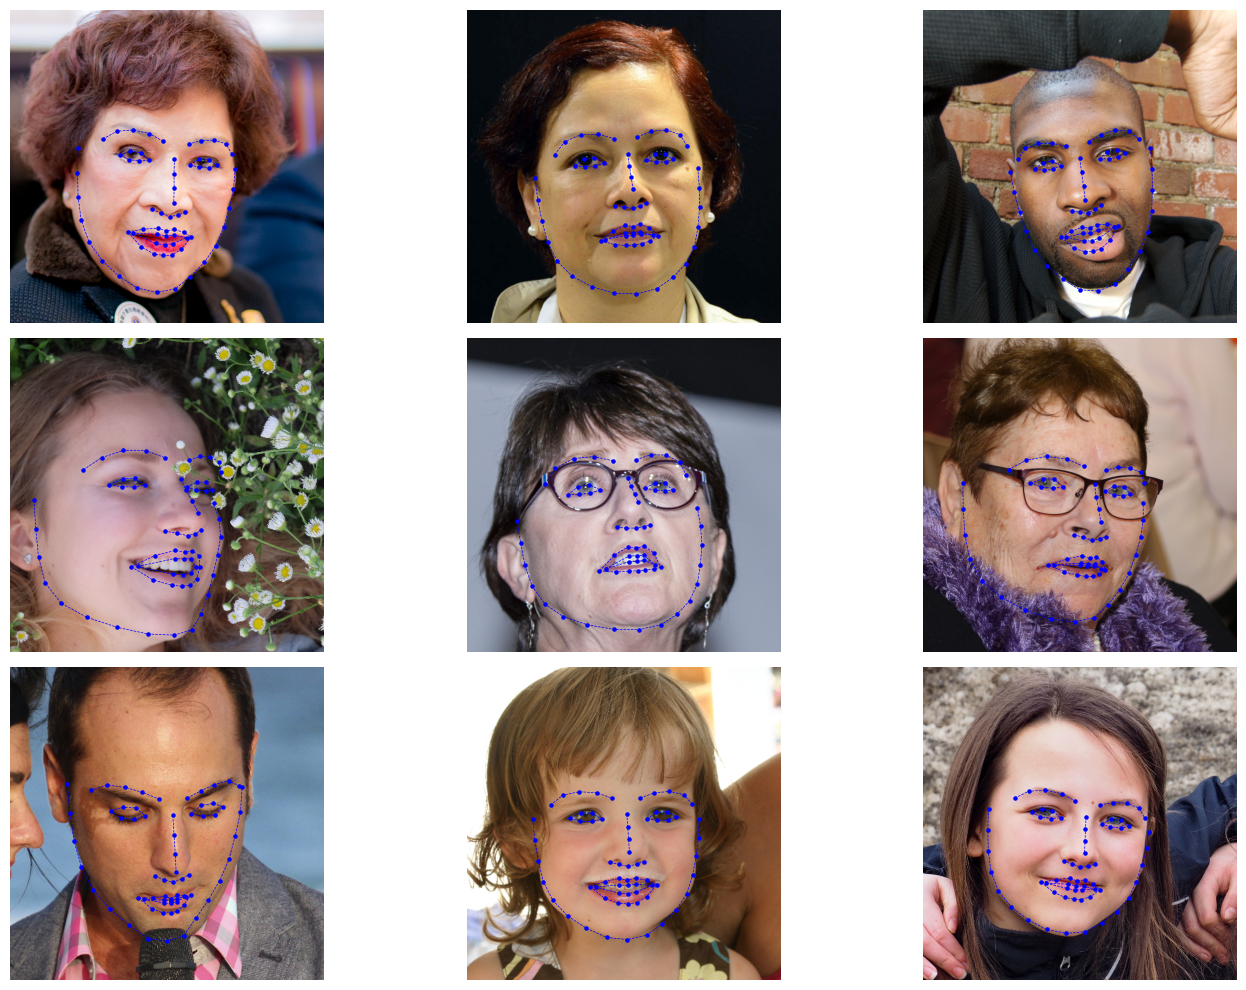

In [13]:
plt.figure(figsize = (15,10))
sampled_indices = np.random.choice(range(len(X_test)), 9, replace = False)
for i in range(0, 9, 1):
    ax = plt.subplot(3, 3, i+1)
    img, tar = preprocess(index = X_test[sampled_indices[i]], anns = annotations, params = params)
    show_prediction(img = img, 
                    model = model, 
                    params = params, 
                    color = 'blue', 
                    point_size = 5, 
                    linewidth = 0.5, 
                    linestyle = '--')
    pass
plt.tight_layout()
plt.show()

## Test on Own Images & Video files
------------------------
Use the model to do facial keypoint estimation on our own "unseen" images and video files in the test folder of this project directory.

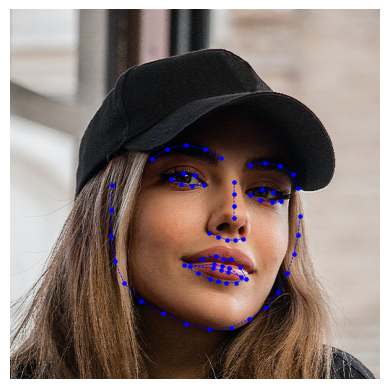

In [14]:
# facial keypoint estimation on our own images in the test folder
filename = 'test_img_1.jpg'

img = cv.cvtColor(cv.imread(os.getcwd() + '/test/images/' + filename), cv.COLOR_BGR2RGB)
img = np.asarray(cv.resize(img, (params['IMG_W'], params['IMG_H'])))
show_prediction(img = img, 
                model = model, 
                params = params, 
                color = 'blue', 
                point_size = 5, 
                linewidth = 0.5, 
                linestyle = '--')

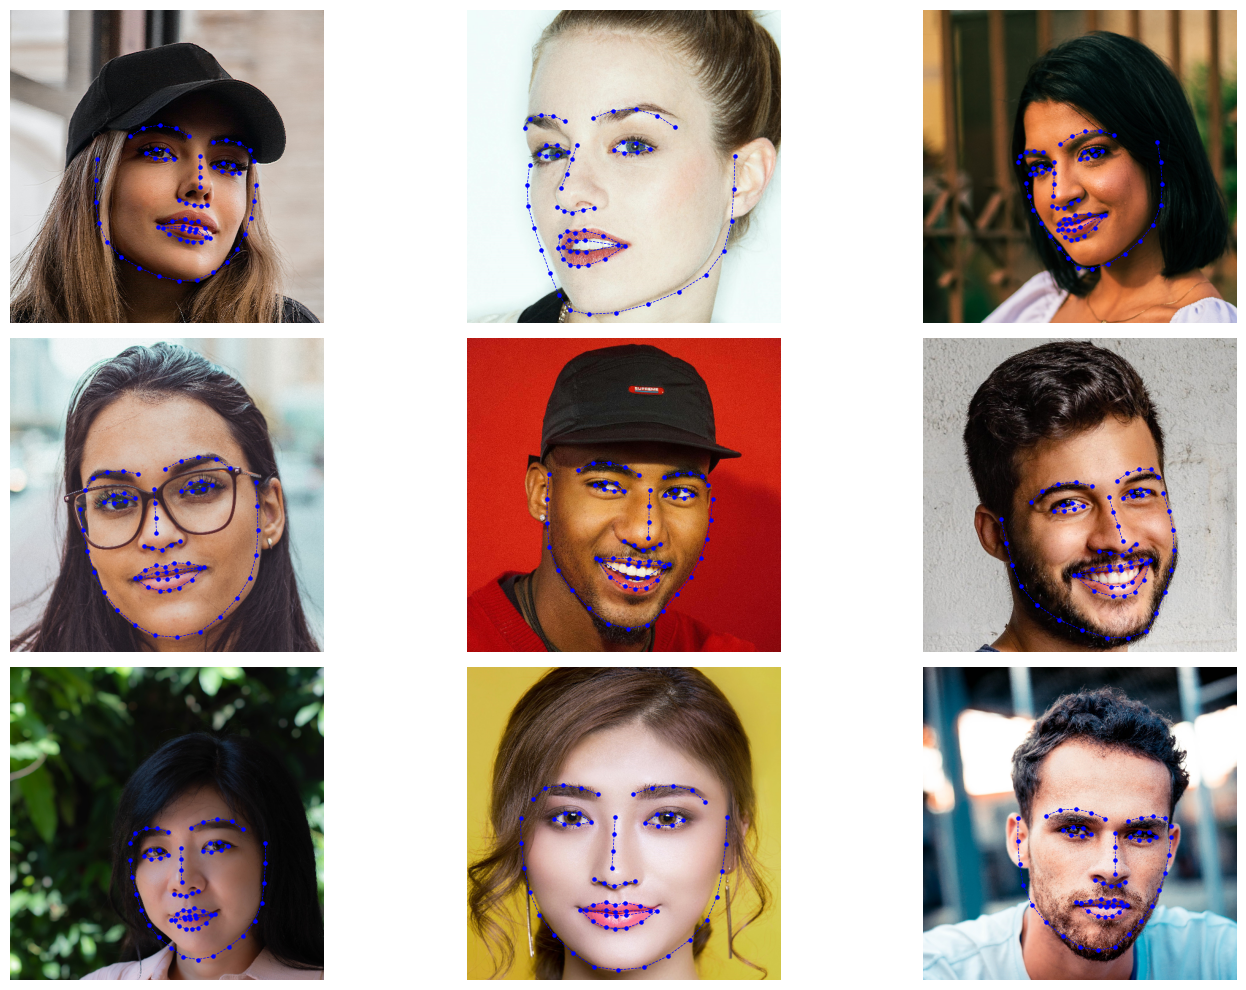

In [15]:
filenames = os.listdir(os.getcwd() + '/test/images')

# facial keypoint estimation on our own images in the test folder
plt.figure(figsize = (15,10))
for i in range(0, 9, 1):
    ax = plt.subplot(3, 3, i+1)
    img = cv.cvtColor(cv.imread(os.getcwd() + '/test/images/' + filenames[i]), cv.COLOR_BGR2RGB)
    img = np.asarray(cv.resize(img, (params['IMG_W'], params['IMG_H'])))

    show_prediction(img = img, 
                    model = model, 
                    params = params, 
                    color = 'blue', 
                    point_size = 5, 
                    linewidth = 0.5, 
                    linestyle = '--')
    pass
plt.tight_layout()
plt.show()

In [18]:
# facial keypoint estimation on our own video files in the test folder
frame_inference_times = predict_video(filename = 'test_video_1.mp4', 
                                      model = model,
                                      params = params,
                                      mp4_output_dims = (540, 540), # (height, width)
                                      generate_gif = True,
                                      gif_output_dims = (240, 240), # (height, width)
                                      gif_quality = 25, # % out of 100%
                                      test_folder = 'test/video/',
                                      fps = 25, # frames per second
                                      color = (255, 0, 0), # BGR
                                      thickness = 5)

Creating video (.mp4)...


100%|████████████████████████████████████████████████████████████████████████████████| 346/346 [00:16<00:00, 21.50it/s]


Creating GIF...


100%|████████████████████████████████████████████████████████████████████████████████| 346/346 [00:05<00:00, 64.68it/s]
